# Identify differential Interactive region

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.path import Path as matpath
import matplotlib.patches as patches
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from random import shuffle
from pathlib import Path

import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# input homer significant interaction table, return intra interactions by chr

def merge_interaction(df, binsize, verbose=False, eps=0.001, min_samples=5):
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    
    coord_df = pd.DataFrame([x, y]).T
    coord_df['chr(1)'] = df['chr(1)'].tolist()[0]
    coord_df['chr(2)'] = df['chr(2)'].tolist()[0]
    
    X = np.array(list(zip(x, y)))
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    if verbose:
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters in %s vs %s: %d' % 
              (df['chr(1)'][0], df['chr(2)'][0], n_clusters_))
    
    coord_df['cluster_dbscan'] = list(map(int, labels))
    return coord_df


def merge_cluster(df):
    square_size = (df['PeakID(1)'].max() - df['PeakID(1)'].min() + 1) * \
                  (df['PeakID(2)'].max() - df['PeakID(2)'].min() + 1)
    real_interaction = df.shape[0]
    precent = real_interaction/square_size
    line = [[df['PeakID(1)'].min(), df['PeakID(1)'].max(), 
                          df['PeakID(2)'].min(), df['PeakID(2)'].max(),
                          real_interaction, square_size, precent]]
    if df['cluster_dbscan'][0] == -1:
        line = [[0, 0, 0, 0, 0, 0, 0]]
    return pd.DataFrame(line, columns=['peak1_start', 'peak1_end', 'peak2_start', 'peak2_end',
                                       'interactions', 'region_size', 'percentage'])


def merge_homer_inter_table(fp, binsize=20000, eps=0.001, min_samples=5, merge=False):
    df_list = []
    df = pd.read_table(fp, index_col=0)
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster

    
def merge_inter_df(df, binsize=20000, eps=0.001, min_samples=5, merge=False):
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster
    
    
def plot_cluster(df, chrom='chr1', region=[1000, 2000], figsize=10, outliers=False, cluster_color = True, unicolor=(0,0.5,0.5)):
    chr_df = df[df['chr(1)'] == chrom]
    
    if outliers:
        out_color = (0.7,0.7,0.7)
    else:
        out_color = (1,1,1)
    if cluster_color:
        colors = sns.color_palette("husl", int(chr_df['cluster_dbscan'].max()) + 1)
        shuffle(colors)
        color_list = chr_df['cluster_dbscan'].apply(lambda i: colors[int(i)] if i != -1 else out_color)
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)'], color_list], index=['x', 'y', 'color']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)'], color_list], index=['x', 'y', 'color']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    else:
        chr_df = chr_df[chr_df['cluster_dbscan'] >= 0]
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)']], index=['x', 'y']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)']], index=['x', 'y']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    fig, ax=plt.subplots()
    fig.set_size_inches(figsize, figsize)
    if cluster_color:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=sub_scatter_df['color'], s=5, marker="s")
    else:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=unicolor, s=5, marker="s")
    ax.set_xlim(region)
    ax.set_ylim(region)
    
    plt.show()
    return


def average_interaction(df, binsize, merge_field, ave_size=3):
    ave_size = ( ave_size // 2 ) * 2 + 1
    expend = ave_size // 2
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    chrom1 = df['chr(1)'][0]
    chrom2 = df['chr(2)'][0]
    
    raw_array = np.zeros((max(x) + 2 * expend, max(y) + 2 * expend))
    for i, row in df.iterrows():
        x_row = int(row['PeakID(1)'].split('-')[1]) // binsize
        y_row = int(row['PeakID(2)'].split('-')[1]) // binsize
        raw_array[x_row + expend, y_row + expend] = row[merge_field]
    total_rows = []
    
    point_set = set()
    for pair in zip(x.tolist(), y.tolist()):
        for i in range(-expend, expend+1):
            for j in range(-expend, expend+1):
                point_set.add((pair[0]+i, pair[1]+j))
    
    for x, y in list(point_set):
        ave_region = raw_array[x : x + 2 * expend + 1, y : y + 2 * expend + 1].flatten()
        ave_value = ave_region[np.nonzero(ave_region)].mean()
        if not np.isnan(ave_value):
            total_rows.append([chrom1, chrom2, chrom1 + '-' + str(x*binsize), chrom2 + '-' + str(y*binsize), ave_value])
    return pd.DataFrame(total_rows, columns=['chr(1)', 'chr(2)', 'PeakID(1)', 'PeakID(2)', merge_field])


def diff_interaction(cd1_df, cd2_df, ave_size=3, binsize=20000, delta_z_cutoff=0.1, eps=0.001, min_samples=17):
    cd1_df_ave = cd1_df.groupby(['chr(1)', 'chr(2)']).apply(average_interaction, binsize, merge_field='Z-score', ave_size=ave_size)
    cd1_df_ave.reset_index(drop=True, inplace=True)
    cd1_df_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)
    
    cd2_df_ave = cd2_df.groupby(['chr(1)', 'chr(2)']).apply(average_interaction, binsize, merge_field='Z-score', ave_size=ave_size)
    cd2_df_ave.reset_index(drop=True, inplace=True)
    cd2_df_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)
    
    df = pd.concat([cd1_df_ave, cd2_df_ave[['Z-score']]], axis=1)
    df.columns = ['chr(1)', 'chr(2)', 'Z-score-1', 'Z-score-2']
    df['Z-score-1'].fillna(0, inplace=True)
    df['Z-score-2'].fillna(0, inplace=True)
    df.reset_index(inplace=True)
    df.drop(['chr(1)', 'chr(2)'], inplace=True, axis=1)
    df['chr(1)'] = df['PeakID(1)'].apply(lambda i: i.split('-')[0])
    df['chr(2)'] = df['PeakID(2)'].apply(lambda i: i.split('-')[0])
    
    df['delta_zscore'] = df['Z-score-1'] - df['Z-score-2']
    df['cd1_only'] = df['Z-score-2'] == 0
    df['cd2_only'] = df['Z-score-1'] == 0
    
    cd1_only = df[df['cd1_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-1']]
    cd1_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']
    
    cd2_only = df[df['cd2_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-2']]
    cd2_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']
    
    cd1_positive = df[df['delta_zscore'] > delta_z_cutoff][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-1']]
    cd2_positive = df[df['delta_zscore'] < -delta_z_cutoff][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-2']]
    cd2_positive.head()
    
    ax = sns.distplot(df['delta_zscore'], bins=500, kde=False, color='steelblue')
    sns.distplot(df['Z-score-1'][df['Z-score-1'] > 0], bins=500, kde=False, color='salmon', ax=ax)
    sns.distplot(-df['Z-score-2'][df['Z-score-2'] > 0], bins=500, kde=False, color='lightseagreen', ax=ax)
    ax.set_xlim((-3, 3))
    
    cd1_positive_cluster = cd1_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                eps=eps, min_samples=min_samples)
    cd2_positive_cluster = cd2_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                eps=eps, min_samples=min_samples)
    return cd1_positive_cluster, cd2_positive_cluster


def read_chrom_matrix(dir_path, condition, chrom, binsize):
    dirp = Path(dir_path)
    fp = dirp / ('%s.%s.%s.tsv' % (condition, chrom, binsize))
    start = time.time()
    chrom_matrix = pd.read_table(fp, index_col=[0, 1])
    col_list = list(map(lambda i: int(i.split('-')[1]) // binsize, chrom_matrix.columns.tolist()))
    chrom_matrix.reset_index(drop=True, inplace=True)
    chrom_matrix.columns = col_list
    end = time.time()
    print('Used %d seconds to read in %s matrix.' % (int(end-start), chrom))
    return chrom_matrix


def color_map(map_series, map_type='cluster', noise_color=(1, 1, 1, 0.5), cmap='hls'):
    if map_type == 'cluster':
        unique_list = map_series.unique()
        color_palette = sns.color_palette(cmap, len(unique_list))
        shuffle(color_palette)
        
        unique_dict = {unique_list[i]: i for i in range(len(unique_list))}
        
        color_list = [color_palette[unique_dict[i]] if i != -1 else noise_color for i in map_series.tolist()]
        return color_list

    
def merge_cluster(df, cluster_column):
    square_size = (df['x'].max() - df['x'].min() + 1) * \
                  (df['y'].max() - df['y'].min() + 1)
    real_interaction = df.shape[0]
    precent = real_interaction/square_size
    line = [[df['x'].min(), df['x'].max(), df['x'].max() - df['x'].min() + 1,
             df['y'].min(), df['y'].max(), df['y'].max() - df['y'].min() + 1,
             square_size, real_interaction, precent]]
    if df[cluster_column].tolist()[0] == -1:
        line = [[0, 0, 0, 0, 0, 0, 0, 0, 0]]
    return pd.DataFrame(line, columns=['x_start', 'x_end', 'x_length', 'y_start', 'y_end', 'y_length',
                                       'region_size', 'interactions', 'percentage'])


def clean_plot(ax, matrix_shape=matrix_shape):
    ax.set_xlim(0, matrix_shape[0])
    ax.set_ylim(0, matrix_shape[1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    sns.despine(left=True, right=True, top=True, bottom=True)
    return ax


def pair_scatter(ax, df, c, point_size=point_size):
    ax.scatter(df['x'], df['y'], marker='s', s=point_size, c=c)
    ax.scatter(df['y'], df['x'], marker='s', s=point_size, c=c)
    return ax


def plot_rect(row, color, ax, lw=0, alpha=0.6, symmetry=True):
    verts = [
       (row['x_start'], row['y_start']),  # left, bottom
       (row['x_start'], row['y_end']),  # left, top
       (row['x_end'], row['y_end']),  # right, top
       (row['x_end'], row['y_start']),  # right, bottom
       (0., 0.),  # ignored
    ]
    verts_sym = [
        (row['y_start'], row['x_start']),  # left, bottom
        (row['y_start'], row['x_end']),  # left, top
        (row['y_end'], row['x_end']),  # right, top
        (row['y_end'], row['x_start']),  # right, bottom
        (0., 0.),  # ignored
    ]

    codes = [
        matpath.MOVETO,
        matpath.LINETO,
        matpath.LINETO,
        matpath.LINETO,
        matpath.CLOSEPOLY,
    ]

    path = matpath(verts, codes)
    path_sym = matpath(verts_sym, codes)
    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=alpha)
    patch_sym = patches.PathPatch(path_sym, facecolor=color, lw=lw, alpha=alpha)
    
    ax.add_patch(patch)
    if symmetry:
        ax.add_patch(patch_sym)
    
    
    return ax


## 1. Set 2 condition

In [2]:
dirp = Path('/Users/hq/Documents/data/hic/')
cd1_df = pd.read_table(dirp / 'dn3' / 'DN3_Interactions_20K.txt', index_col=0)
cd2_df = pd.read_table(dirp / 'dp' / 'DP_Interactions_20K.txt', index_col=0)

## 2. Do clustering
- set eps and min_samples to control DBSCAN. Parameters for raw and after moving average should be different.
- set ave_size for moving average.
- set delta_z_cutoff to determine close Z-score.

Used 50 seconds.


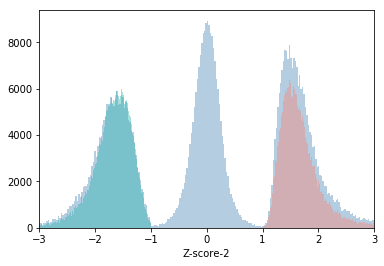

In [171]:
start = time.time()
cd1_raw_cluster = cd1_df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)
cd2_raw_cluster = cd2_df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)

cd1_positive_cluster, cd2_positive_cluster = diff_interaction(cd1_df, cd2_df, ave_size=3, binsize=20000, 
                                                              delta_z_cutoff=1, eps=0.001, min_samples=17)
end = time.time()
print('Used %d seconds.' % int(end-start))

cd1_raw_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd1_raw_cluster.drop('chr(2)', inplace=True, axis=1)
cd2_raw_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd2_raw_cluster.drop('chr(2)', inplace=True, axis=1)
cd1_positive_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd1_positive_cluster.drop('chr(2)', inplace=True, axis=1)
cd2_positive_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd2_positive_cluster.drop('chr(2)', inplace=True, axis=1)

summary_df = pd.concat([cd1_raw_cluster, cd2_raw_cluster, cd1_positive_cluster, cd2_positive_cluster], axis=1)
summary_df.reset_index(inplace=True)
summary_df.columns = ['x', 'y', 'chrom', 'cd1_raw_cluster', 'cd2_raw_cluster', 'cd1_positive_cluster', 'cd2_positive_cluster']
summary_df = summary_df[summary_df['x'] >= summary_df['y']]

## 3. Draw some plots
### Prepare Data

In [94]:
matrix_dir = '/Users/hq/Documents/data/hic'
check_condition = 'dn3'
chrom = 'chr1'
x_select = slice(4500, 4800)
y_select = slice(4500, 4800)

In [67]:
chrom_matrix = read_chrom_matrix(dir_path=matrix_dir,
                                 condition=check_condition, chrom=chrom, binsize=20000)

Used 37 seconds to read in chr1 matrix.


In [95]:
heatmap_matrix = chrom_matrix.iloc[x_select, y_select]
interaction_select = summary_df[(summary_df['chrom'] == chrom) & 
                                (summary_df['x'] > x_select.start) & (summary_df['x'] < x_select.stop) & 
                                (summary_df['y'] > y_select.start) & (summary_df['y'] < y_select.stop)]
interaction_select['x'] = interaction_select['x'] - x_select.start
interaction_select['y'] = interaction_select['y'] - y_select.start

cd1_raw_interaction = interaction_select[~interaction_select['cd1_raw_cluster'].isnull()]
cd1_raw_interaction_clean = cd1_raw_interaction[cd1_raw_interaction['cd1_raw_cluster'] != -1]

cd2_raw_interaction = interaction_select[~interaction_select['cd2_raw_cluster'].isnull()]
cd2_raw_interaction_clean = cd2_raw_interaction[cd2_raw_interaction['cd2_raw_cluster'] != -1]

cd1_positive_interaction = interaction_select[~interaction_select['cd1_positive_cluster'].isnull()]
cd1_positive_interaction_clean = cd1_positive_interaction[cd1_positive_interaction['cd1_positive_cluster'] != -1]

cd2_positive_interaction = interaction_select[~interaction_select['cd2_positive_cluster'].isnull()]
cd2_positive_interaction_clean = cd2_positive_interaction[cd2_positive_interaction['cd2_positive_cluster'] != -1]

### Figure setting

In [99]:
figsize = 10
matrix_shape = (x_select.stop-x_select.start, y_select.stop-y_select.start)
point_size = (figsize / max(matrix_shape)) * 200


### Raw matrix and raw interactions generated by Homer

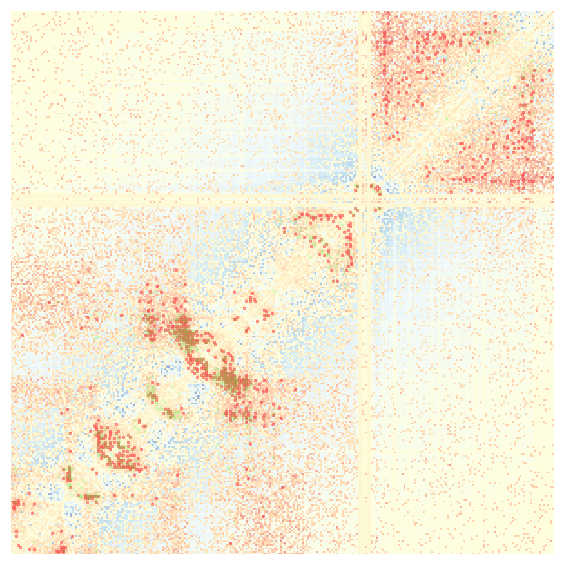

In [100]:
another_condition = True

fig, ax = plt.subplots()
fig.set_size_inches(figsize, figsize)
ax.imshow(heatmap_matrix, cmap='RdYlBu_r', alpha=0.5)

df_scatter = cd1_raw_interaction
ax = pair_scatter(ax, df_scatter, c=(1, 0.3, 0.3, 0.5))

if another_condition:
    df_scatter = cd2_raw_interaction
    ax = pair_scatter(ax, df_scatter, c=(0.3, 1, 0.3, 0.1))

ax = clean_plot(ax)
plt.show()

## Basic DBSCAN  clustering

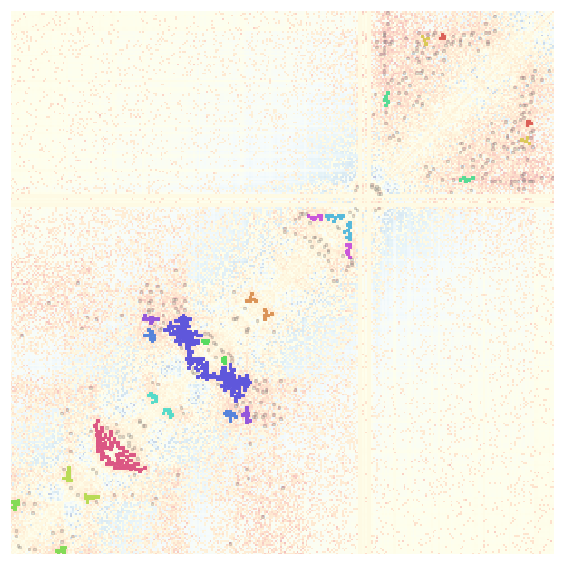

In [101]:
another_condition = False

fig, ax = plt.subplots()
fig.set_size_inches(figsize, figsize)
ax.imshow(heatmap_matrix, cmap='RdYlBu_r', alpha=0.3)

df_scatter = cd1_raw_interaction
ax = pair_scatter(ax, df_scatter, c=color_map(df_scatter['cd1_raw_cluster'], noise_color=(0.4, 0.4, 0.4, 0.2)))

if another_condition:
    df_scatter = cd2_raw_interaction
    ax = pair_scatter(ax, df_scatter, c=(0.3, 1, 0.3, 0.5))

ax = clean_plot(ax)
plt.show()

### Diff Interact Region

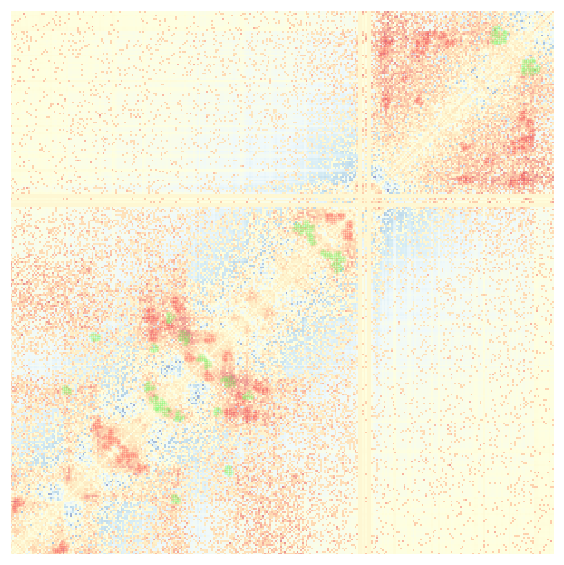

In [102]:
another_condition = True

fig, ax = plt.subplots()
fig.set_size_inches(figsize, figsize)
ax.imshow(heatmap_matrix, cmap='RdYlBu_r', alpha=0.5)


#df_scatter = cd1_raw_interaction
#ax = pair_scatter(ax, df_scatter, c=[0.5, 0.1, 0.1, 0.5])
#df_scatter = cd2_raw_interaction
#ax = pair_scatter(ax, df_scatter, c=[0.1, 0.5, 0.1, 0.5])

df_scatter = cd1_positive_interaction_clean
ax = pair_scatter(ax, df_scatter, c=(1, 0.3, 0.3, 0.1))

if another_condition:
    df_scatter = cd2_positive_interaction_clean
    ax = pair_scatter(ax, df_scatter, c=(0.3, 1, 0.3, 0.1))

ax = clean_plot(ax)
plt.show()

### Diff interaction square

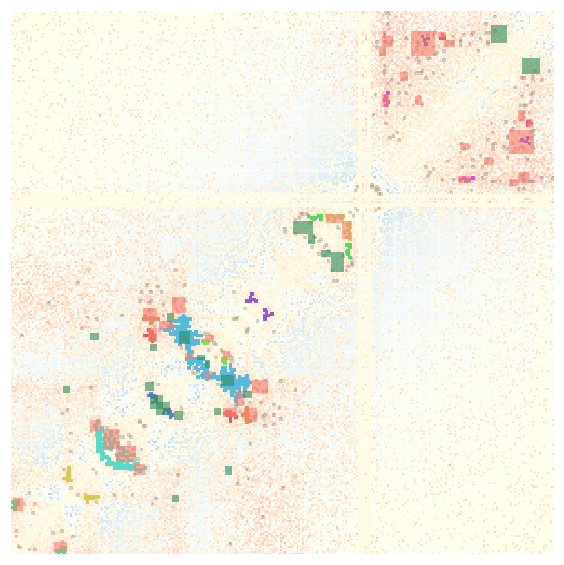

In [107]:
another_condition = True

cd1_positive_rectangle = cd1_positive_interaction.groupby(['cd1_positive_cluster', 'chrom']).apply(merge_cluster, cluster_column='cd1_positive_cluster')
cd2_positive_rectangle = cd2_positive_interaction.groupby(['cd2_positive_cluster', 'chrom']).apply(merge_cluster, cluster_column='cd2_positive_cluster')

fig, ax = plt.subplots()
fig.set_size_inches(figsize, figsize)
ax.imshow(heatmap_matrix, cmap='RdYlBu_r', alpha=0.3)

df_scatter = cd1_raw_interaction
ax = pair_scatter(ax, df_scatter, c=color_map(df_scatter['cd1_raw_cluster'], noise_color=(0.4, 0.4, 0.4, 0.2)))

df_rect = cd1_positive_rectangle
df_rect.apply(plot_rect, axis=1, color='salmon', ax=ax, lw=0)


if another_condition:
    df_rect = cd2_positive_rectangle
    df_rect.apply(plot_rect, axis=1, color='seagreen', ax=ax, lw=0)



ax = clean_plot(ax)
plt.show()

In [172]:
cd1_raw_interaction = summary_df[~summary_df['cd1_raw_cluster'].isnull()]
cd1_raw_interaction_clean = cd1_raw_interaction[cd1_raw_interaction['cd1_raw_cluster'] != -1]

cd2_raw_interaction = summary_df[~summary_df['cd2_raw_cluster'].isnull()]
cd2_raw_interaction_clean = cd2_raw_interaction[cd2_raw_interaction['cd2_raw_cluster'] != -1]

cd1_positive_interaction = summary_df[~summary_df['cd1_positive_cluster'].isnull()]
cd1_positive_interaction_clean = cd1_positive_interaction[cd1_positive_interaction['cd1_positive_cluster'] != -1]

cd2_positive_interaction = summary_df[~summary_df['cd2_positive_cluster'].isnull()]
cd2_positive_interaction_clean = cd2_positive_interaction[cd2_positive_interaction['cd2_positive_cluster'] != -1]

In [173]:
cd1_positive_rect = cd1_positive_interaction_clean.groupby(['cd1_positive_cluster', 'chrom']).apply(merge_cluster, cluster_column='cd1_positive_cluster')
cd2_positive_rect = cd2_positive_interaction_clean.groupby(['cd2_positive_cluster', 'chrom']).apply(merge_cluster, cluster_column='cd2_positive_cluster')

In [174]:
print('DN2 positive', cd1_positive_rect.shape[0])
print(cd1_positive_rect.index.get_level_values('chrom').value_counts())


print('DP positive', cd2_positive_rect.shape[0])
print(cd2_positive_rect.index.get_level_values('chrom').value_counts())

raw_interaction_counts = cd1_df['chr(1)'].value_counts()
chrom_size = {'chr1': 195471971, 'chr2': 182113224, 'chr3': 160039680, 'chr4': 156508116, 'chr5': 151834684, 'chr6': 149736546, 'chr7': 145441459, 'chr8': 129401213, 'chr9': 124595110, 'chr10': 130694993, 'chr11': 122082543, 'chr12': 120129022, 'chr13': 120421639, 'chr14': 124902244, 'chr15': 104043685, 'chr16': 98207768, 'chr17': 94987271, 'chr18': 90702639, 'chr19': 61431566, 'chrX': 171031299, 'chrY': 91744698, 'chrM': 16299}
l = [(chrom, count * 100000 / chrom_size[chrom]) for chrom, count in raw_interaction_counts.iteritems()]
l

DN2 positive 354
chr2    153
chr1     98
chr5     96
chrX      7
Name: chrom, dtype: int64
DP positive 142
chr2    73
chr1    58
chrX    11
Name: chrom, dtype: int64


[('chr2', 4.541680070415974),
 ('chr11', 5.83785349228841),
 ('chr1', 3.5984698798581203),
 ('chr9', 4.48974281574935),
 ('chr6', 3.4801123300920804),
 ('chr13', 4.3057045586300315),
 ('chr10', 3.8134590205762513),
 ('chr5', 3.1797741285515504),
 ('chr15', 4.6096022069960325),
 ('chr4', 2.8976133097148775),
 ('chr3', 2.797431237053211),
 ('chr7', 3.0259597437069163),
 ('chr12', 3.2573311052178546),
 ('chr17', 3.9415807619107195),
 ('chr8', 2.7325864402832143),
 ('chr14', 2.6444681009894424),
 ('chr16', 3.3347667569433),
 ('chr18', 2.976760135942682),
 ('chr19', 3.7195861163623927),
 ('chrX', 0.40226555257584756),
 ('chrY', 0.07629868703693374)]

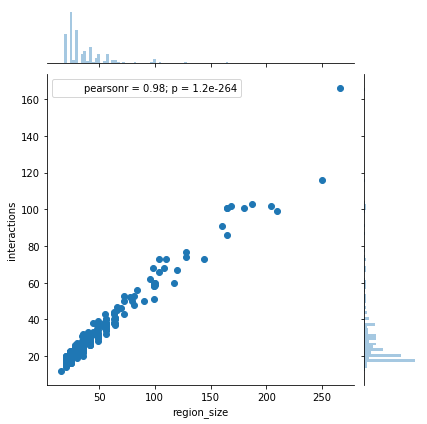

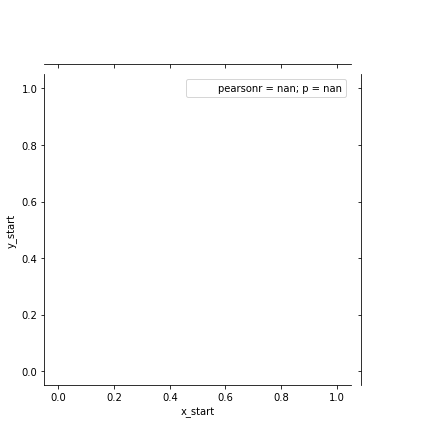

In [177]:
sns.jointplot(x='region_size', y='interactions', data=cd1_positive_rect, marginal_kws=dict(bins=100))
sns.jointplot(x='x_start', y='y_start', data=cd2_positive_rect[cd2_positive_rect.index.get_level_values('chrom') == 'chr5'], marginal_kws=dict(bins=100))